In [1]:
# cnn lstm model
from numpy import mean
from numpy import std
import seaborn as sns
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from sklearn.metrics import classification_report
from keras.layers import Permute, Reshape
from sklearn import metrics
from sklearn.metrics import classification_report
from matplotlib import pyplot
import numpy as np
import pandas as pd

**DATA EXPLORATION**

In [2]:
features=list()
with open('UCI HAR Dataset/features.txt') as feat:
    features=[l.split()[1] for l in feat.readlines()]
print("Number of features = {}".format(len(features)))
for f in features:
    print(f,end=" | ")


Number of features = 561
tBodyAcc-mean()-X | tBodyAcc-mean()-Y | tBodyAcc-mean()-Z | tBodyAcc-std()-X | tBodyAcc-std()-Y | tBodyAcc-std()-Z | tBodyAcc-mad()-X | tBodyAcc-mad()-Y | tBodyAcc-mad()-Z | tBodyAcc-max()-X | tBodyAcc-max()-Y | tBodyAcc-max()-Z | tBodyAcc-min()-X | tBodyAcc-min()-Y | tBodyAcc-min()-Z | tBodyAcc-sma() | tBodyAcc-energy()-X | tBodyAcc-energy()-Y | tBodyAcc-energy()-Z | tBodyAcc-iqr()-X | tBodyAcc-iqr()-Y | tBodyAcc-iqr()-Z | tBodyAcc-entropy()-X | tBodyAcc-entropy()-Y | tBodyAcc-entropy()-Z | tBodyAcc-arCoeff()-X,1 | tBodyAcc-arCoeff()-X,2 | tBodyAcc-arCoeff()-X,3 | tBodyAcc-arCoeff()-X,4 | tBodyAcc-arCoeff()-Y,1 | tBodyAcc-arCoeff()-Y,2 | tBodyAcc-arCoeff()-Y,3 | tBodyAcc-arCoeff()-Y,4 | tBodyAcc-arCoeff()-Z,1 | tBodyAcc-arCoeff()-Z,2 | tBodyAcc-arCoeff()-Z,3 | tBodyAcc-arCoeff()-Z,4 | tBodyAcc-correlation()-X,Y | tBodyAcc-correlation()-X,Z | tBodyAcc-correlation()-Y,Z | tGravityAcc-mean()-X | tGravityAcc-mean()-Y | tGravityAcc-mean()-Z | tGravityAcc-std()-X | 

**Exploring Train Data**

In [3]:
train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None, encoding='latin-1')
train.columns = features
train['subject'] = pd.read_csv('UCI HAR dataset/train/subject_train.txt', header=None, squeeze=True)
train['Activity'] = pd.read_csv('UCI HAR dataset/train/y_train.txt', names=['Activity'], squeeze=True)
train['ActivityName'] = train['Activity'].map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})
train.sample()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
6096,0.287315,-0.02414,-0.121429,-0.991233,-0.970404,-0.966698,-0.992739,-0.968671,-0.962306,-0.931601,...,0.090148,-0.011355,-0.054214,0.144182,-0.525243,-0.113144,-0.238601,27,4,SITTING


In [4]:
train.shape

(7352, 564)

In [5]:
test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None, encoding='latin-1')
test.columns = features
test['subject'] = pd.read_csv('UCI HAR dataset/test/subject_test.txt', header=None, squeeze=True)
test['Activity'] = pd.read_csv('UCI HAR dataset/test/y_test.txt', names=['Activity'], squeeze=True)
test['ActivityName'] = train['Activity'].map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})
test.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
618,0.179157,-0.022887,-0.155675,-0.143989,-0.108818,-0.341028,-0.240542,-0.123563,-0.331946,0.083637,...,0.585817,0.126523,0.864032,-0.839005,-0.768422,0.24919,-0.036596,4,2,WALKING


In [6]:
test.shape

(2947, 564)

**Checking for Duplicates and Nulls**

In [7]:
print('Duplicates in train = {}'.format(sum(train.duplicated())))
print('Duplicates in test = {}'.format(sum(test.duplicated())))
print('Invalid values in train = {}'.format(train.isnull().values.sum()))
print('Invalid values in test = {}'.format(test.isnull().values.sum()))

Duplicates in train = 0
Duplicates in test = 0
Invalid values in train = 0
Invalid values in test = 0


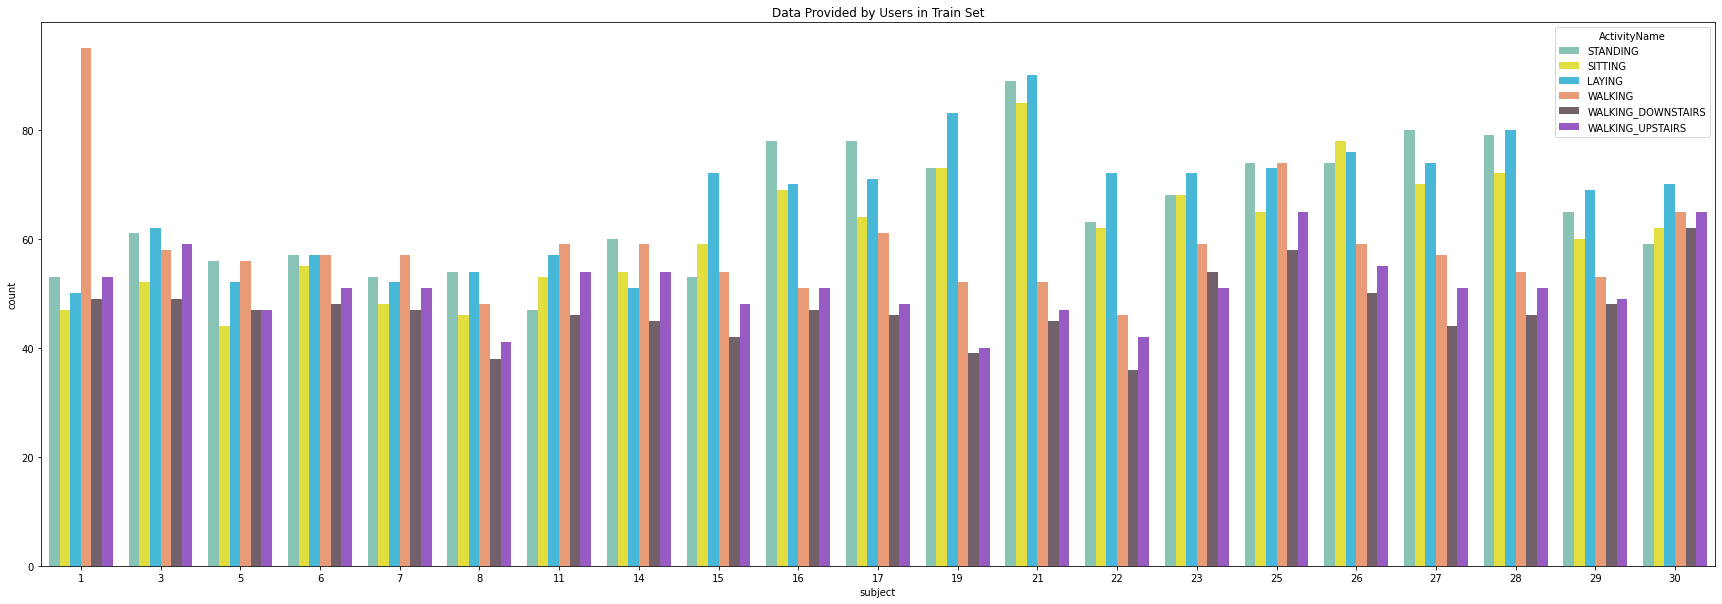

In [8]:
pyplot.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = train)
pyplot.title('Data Provided by Users in Train Set')
pyplot.show()

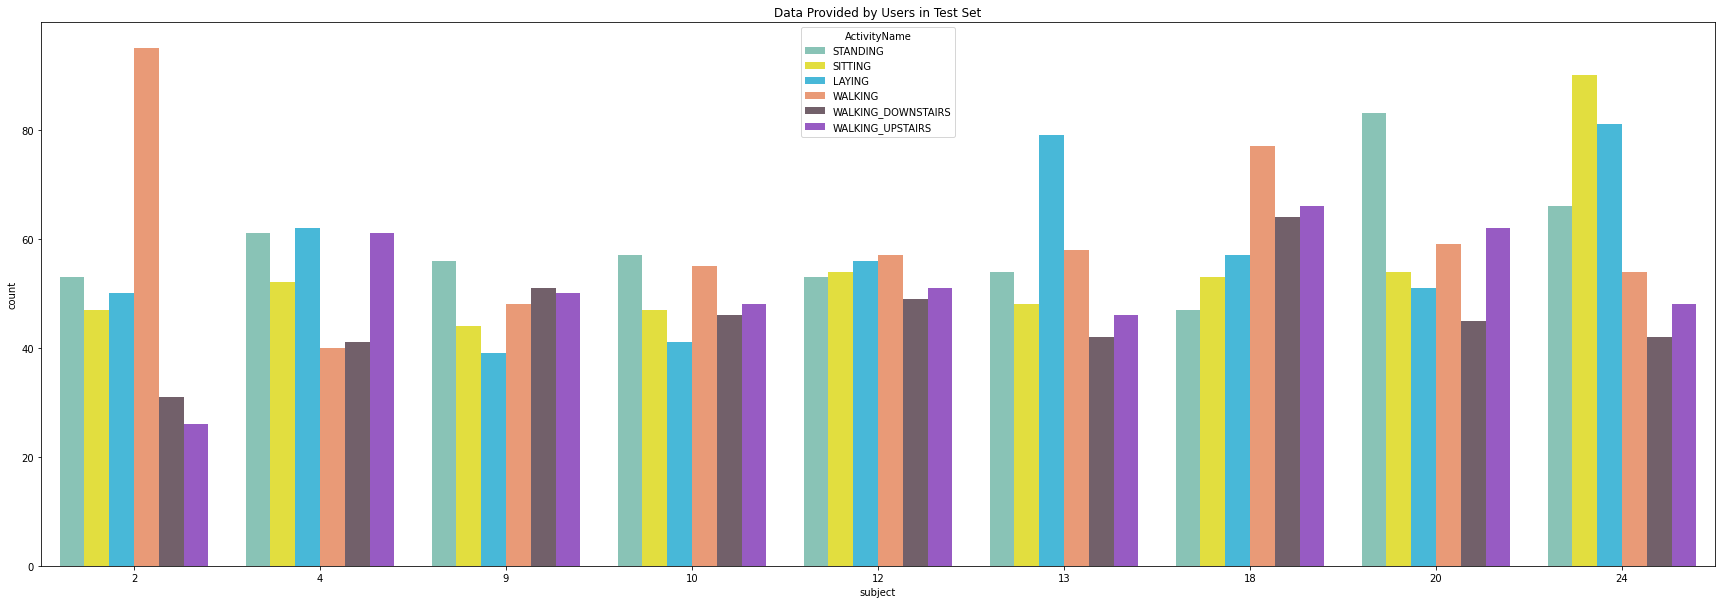

In [9]:
pyplot.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = test)
pyplot.title('Data Provided by Users in Test Set')
pyplot.show()

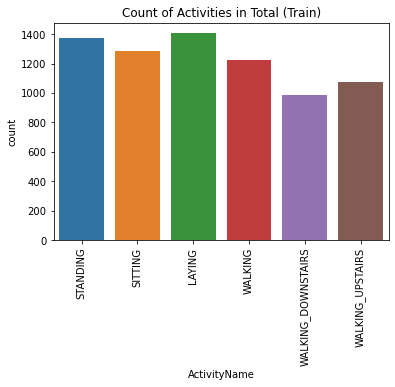

In [10]:
pyplot.title('Count of Activities in Total (Train)')
sns.countplot(x="ActivityName",data=train)
pyplot.xticks(rotation=90)
pyplot.show()

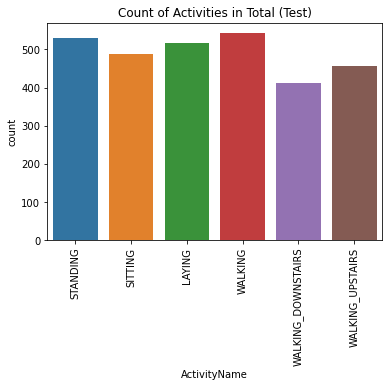

In [11]:
pyplot.title('Count of Activities in Total (Test)')
sns.countplot(x="ActivityName",data=test)
pyplot.xticks(rotation=90)
pyplot.show()

**CNN-LSTM Model**

In [12]:
def file_load(filepath):
    df = read_csv(filepath, header=None, delim_whitespace=True)
    return df.values    


In [13]:
def train_test_append(filenames, append_before=''):
    datalist = list()
    for name in filenames:
        data = file_load(append_before + name)
        datalist.append(data)
    datalist = dstack(datalist)
    return datalist


In [14]:
def inertial_signals_load(group, append_before=''):
    filepath = append_before + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = train_test_append(filenames, filepath)
    y = file_load(append_before + group + '/y_'+group+'.txt')
    return X, y
    

In [15]:
def load_dataset(append_before=''):
    trainX, trainy = inertial_signals_load('train', append_before + 'UCI HAR Dataset/')
    testX, testy = inertial_signals_load('test', append_before + 'UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy
    

In [21]:
trainX, trainy, testX, testy = load_dataset()
verbose, epochs, batch_size = 0, 400, 150
n_timesteps = trainX.shape[1]
n_features = trainX.shape[2]
n_outputs = trainy.shape[1]
n_steps = 4
n_length = 32
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features)) 
print(trainX.shape,testX.shape)


(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 4, 32, 9) (2947, 4, 32, 9)


In [22]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    

In [23]:
history=model.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, batch_size=batch_size, verbose=verbose)
loss , accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
#print(model.summary()) 
score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 93.99389028549194


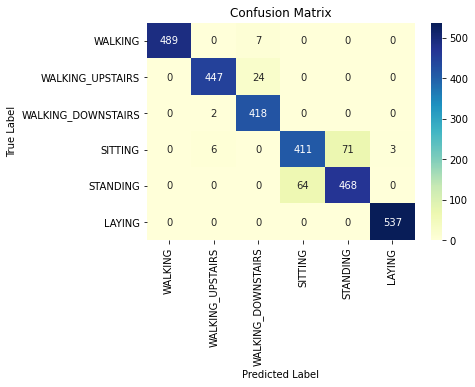

In [24]:
import matplotlib.pyplot as plt
ypred_train = model.predict(trainX)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = model.predict(testX)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [25]:
clr=metrics.classification_report(max_ytest, max_ypred_test)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       496
           1       0.98      0.95      0.97       471
           2       0.93      1.00      0.96       420
           3       0.87      0.84      0.85       491
           4       0.87      0.88      0.87       532
           5       0.99      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947

